In [5]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from pandas.tools.plotting import table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
conn = psycopg2.connect(database="dreamteam_csgodb", user="postgres", password="p0stgr3s", host="localhost", port="5432")
cur = conn.cursor()

### Top ten ranked countries

In [12]:
cur.execute('''SELECT d.name, avg(c.rating) country_rate, sum(c.num_rates) num_rates
                FROM core.users a, core.profiles b, games.profiles_ratings c, data.countries d
                WHERE a.id=b.user_id and b.id=c.profile_id and a.country=d.code
                GROUP BY d.name
                ORDER BY country_rate desc''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_ranks_df = pd.DataFrame(rows, columns = col_names)

Text(0,0.5,'Average rate')

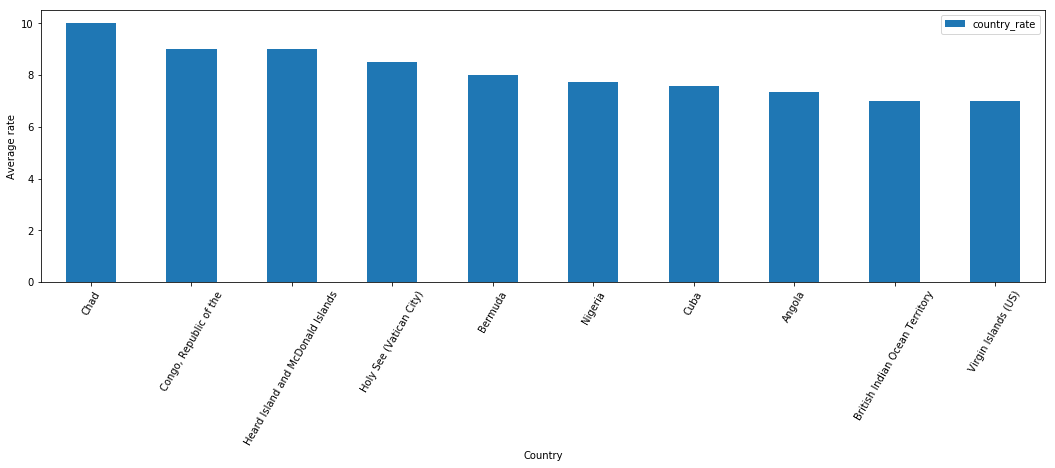

In [13]:
top10 = country_ranks_df.head(10)
top10.set_index(["name"],inplace=True)
top10.plot(y=['country_rate'], kind='bar', rot=60, figsize=(18, 5))
plt.xlabel("Country")
plt.ylabel("Average rate")

In [5]:
cur.execute('''SELECT f.name, avg(c.rating) region_rate, sum(c.num_rates) num_rates
               FROM core.users a, core.profiles b, games.profiles_ratings c, data.countries d, 
                    data.regions_countries e, data.regions f
               WHERE a.id=b.user_id and b.id=c.profile_id and a.country=d.code and d.code=e.country and 
                     f.id=e.region_id
               GROUP BY f.name
               ORDER BY region_rate desc''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
region_ranks_df = pd.DataFrame(rows, columns = col_names)

Text(0,0.5,'Average rate')

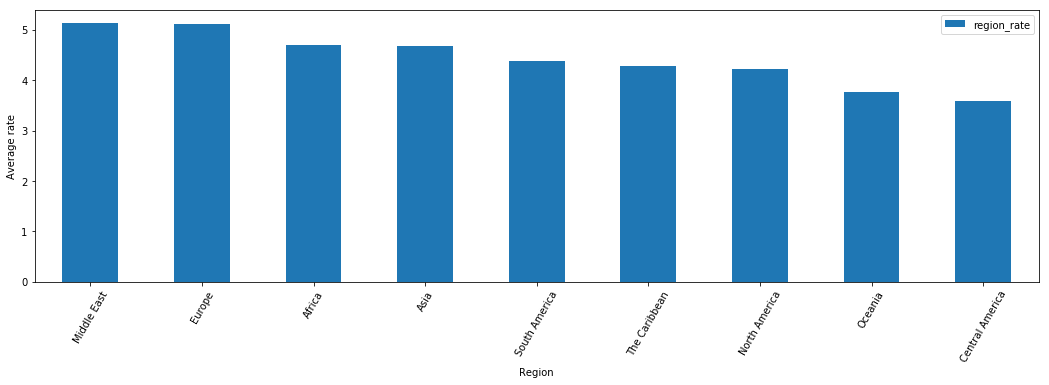

In [6]:
region_ranks_df.set_index(["name"],inplace=True)
region_ranks_df.plot(y=['region_rate'], kind='bar', rot=60, figsize=(18, 5))
plt.xlabel("Region")
plt.ylabel("Average rate")

### Correlations between players, maps and weapons statistics

In [7]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, 
                      CASE 
                        WHEN (a.gender='m') THEN 1
                        WHEN (a.gender='f') THEN 2
                        ELSE 0
                      END AS gender, e.country_id, f.rating, g.total_kills, 
                      g.total_time_played, g.total_deaths, g.total_kills_headshot, g.total_shots_hit, g.total_mvps, 
                      g.total_wins, g.total_rounds_played, g.total_shots_fired, g.rank_id, g.goal_id, 
                      h.map_total_rounds, h.map_total_wins, g.total_kills/g.total_deaths as KD
               FROM core.users a
               INNER JOIN core.profiles b ON a.id=b.user_id
               INNER JOIN games.profiles_roles c ON b.id=c.profile_id
               INNER JOIN games.roles d ON c.role_id=d.id
               INNER JOIN (SELECT ROW_NUMBER() OVER (ORDER BY 1) AS country_id, * from data.countries) e ON a.country=e.code
               INNER JOIN games.profiles_ratings f ON b.id=f.profile_id
               INNER JOIN csgo.profiles g ON a.id=g.user_id
               INNER JOIN (SELECT user_id, sum(total_rounds) AS map_total_rounds, sum(total_wins) as map_total_wins
                           FROM csgo.maps_stats
                           GROUP BY user_id) h ON g.user_id=h.user_id
                  WHERE d.name = 'sniper'
                        AND g.total_kills_headshot IS NOT NULL
                        AND g.total_kills / 9 <= h.map_total_rounds
                        AND g.total_kills_headshot <= g.total_kills
                        AND g.total_kills_headshot < 4000000''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
csgo_players_df = pd.DataFrame(rows, columns = col_names)

In [8]:
print(csgo_players_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41043 entries, 0 to 41042
Data columns (total 18 columns):
age                     41043 non-null float64
gender                  41043 non-null int64
country_id              41043 non-null int64
rating                  41043 non-null float64
total_kills             41043 non-null int64
total_time_played       41043 non-null int64
total_deaths            41041 non-null float64
total_kills_headshot    41043 non-null int64
total_shots_hit         41043 non-null int64
total_mvps              41026 non-null float64
total_wins              41043 non-null int64
total_rounds_played     41043 non-null int64
total_shots_fired       41043 non-null int64
rank_id                 41043 non-null int64
goal_id                 41043 non-null int64
map_total_rounds        41043 non-null int64
map_total_wins          41043 non-null int64
kd                      41041 non-null float64
dtypes: float64(5), int64(13)
memory usage: 5.6 MB
None


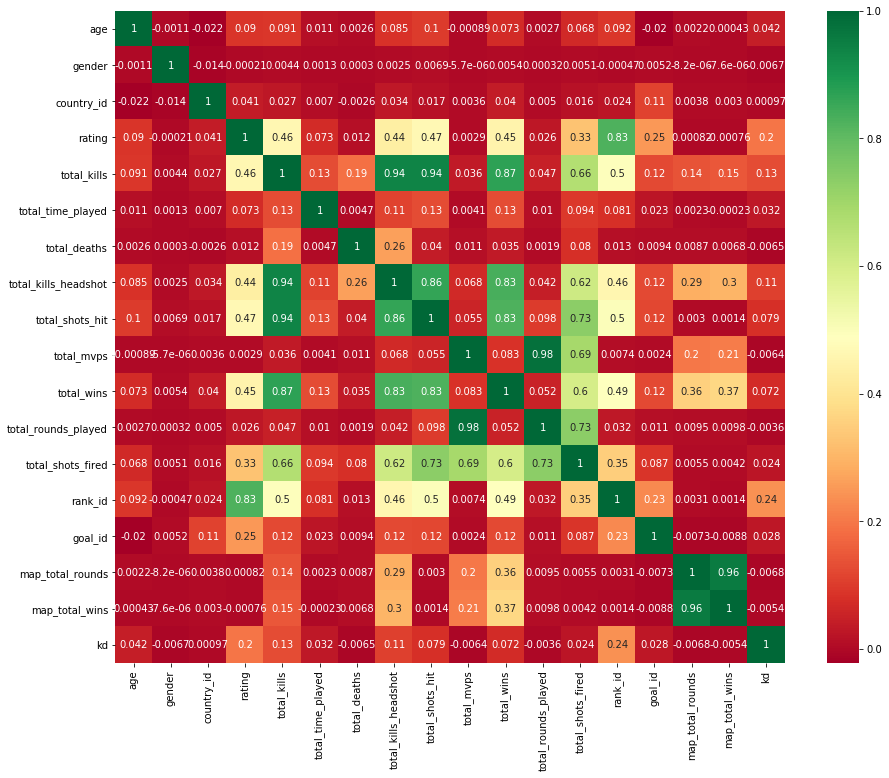

In [9]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(csgo_players_df.corr(), annot=True, cbar=True, cmap="RdYlGn")

From the above heat map the most interesting correlations, and likely causations are:
- Total shots hit <--> total shots fired
- Total kills headshots --> total wins
- Total kills --> total wins
- Total rounds played --> total mvps

### Analyzing correlations between age/country and weapons usage

In [69]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, b.weapon_id, c.total_kills, c.total_hits, c.total_shots
               FROM core.users a, 
                    (SELECT ROW_NUMBER() OVER (ORDER BY 1) AS weapon_id, * from csgo.weapons) b, 
                    csgo.weapons_stats c
               WHERE b.name=c.weapon_name and a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
age_weapons_stats = pd.DataFrame(rows, columns = col_names)

cur.execute('''SELECT b.region_id, c.weapon_name, c.total_kills, c.total_hits, c.total_shots
               FROM core.users a 
               INNER JOIN data.regions_countries b on a.country=b.country
               INNER JOIN csgo.weapons_stats c on a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_weapons_stats = pd.DataFrame(rows, columns = col_names)

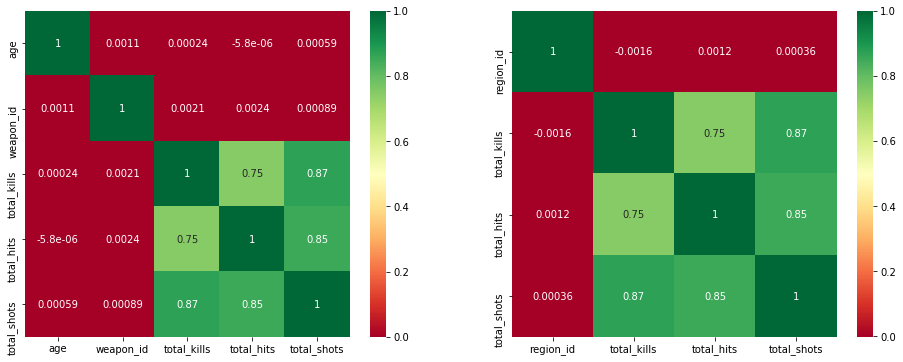

In [70]:
f = plt.figure(figsize=(16, 6))

ax = f.add_subplot(1, 2, 1, label='plot1')
sns.heatmap(age_weapons_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

ax = f.add_subplot(1, 2, 2, label='plot2')
sns.heatmap(country_weapons_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

### Analyzing correlations between age/country and map statistics

In [71]:
cur.execute('''SELECT date_part('year',age(a.birthday)) age, c.total_rounds, c.total_wins, b.map_id
               FROM core.users a,
                    (SELECT DISTINCT map_name, DENSE_RANK() OVER (ORDER BY map_name) map_id
                     FROM csgo.maps_stats
                     ORDER BY map_name, map_id) b,
                    csgo.maps_stats c
               WHERE b.map_name=c.map_name and a.id = c.user_id''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
age_map_stats = pd.DataFrame(rows, columns = col_names)

cur.execute('''SELECT b.region_id, c.total_rounds, c.total_wins, d.map_id
               FROM core.users a,
                    data.regions_countries b,
                    csgo.maps_stats c,
                    (SELECT DISTINCT map_name, DENSE_RANK() OVER (ORDER BY map_name) map_id
                     FROM csgo.maps_stats
                     ORDER BY map_name, map_id) d
               WHERE a.id = c.user_id and a.country=b.country and d.map_name=c.map_name and a.id = c.user_id''')
rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
country_map_stats = pd.DataFrame(rows, columns = col_names)

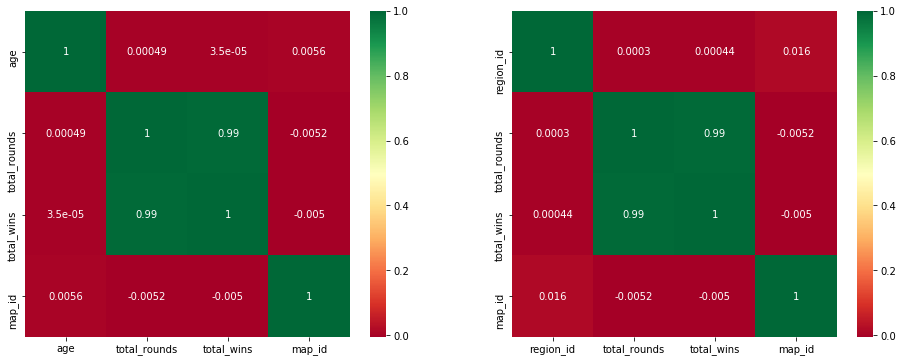

In [72]:
f = plt.figure(figsize=(16, 6))

ax = f.add_subplot(1, 2, 1, label='plot1')
sns.heatmap(age_map_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

ax = f.add_subplot(1, 2, 2, label='plot2')
sns.heatmap(country_map_stats.corr(), annot=True, cbar=True, cmap="RdYlGn")

In [27]:
cur.execute('''select distinct(a.nickname) NICKNAME, max(a.rank_id) as Rank, max(b.rating) as Rating
                from csgo.profiles a
                inner join games.profiles_ratings b on a.user_id = b.profile_id
                where nickname IN ('XANTARES', 'coldzera', 's1mple', 'CeRq', 'NiKo', 'Calyx', 'device', 'kennyS')
                group by a.nickname
                order by rating asc''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

In [31]:
top_players_stats = pd.DataFrame(rows, columns = col_names)
top_players_stats['hltv_rating'] = pd.Series([1.25, 1.17, 1.16, 1.2, 1.22], index=top_players_stats.index)

/Users/dcamacho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  """


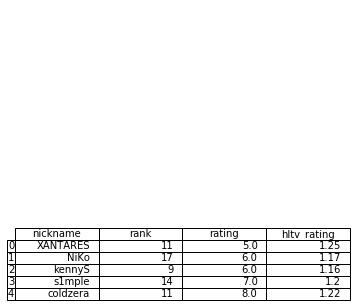

In [36]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, top_players_stats)  # where df is your data frame

plt.savefig('mytable.png')

In [51]:
cur.execute('''SELECT 0.9431295+0.0474294*a.total_kills-0.0445878*a.total_deaths as rate_v1,
       a.total_wins,
       a.total_mvps,
       a.total_kills_headshot,
       (cast(a.total_shots_hit as decimal)/ cast(a.total_shots_fired as decimal)) as accuracy,
       b.demolition,
       c.pistol,
       c.submachine,
       c.shotgun,
       a.rank_id
    FROM csgo.profiles a,

    (SELECT b.user_id,
            SUM(total_wins * b.demolition) AS demolition
     FROM
    (SELECT user_id, SUM(total_wins) AS total_wins, demolition 
     FROM (SELECT name,
                  COUNT(CASE WHEN name = 'de_aztec' OR
                                  name = 'de_bank' OR 
                                  name = 'de_cache' OR
                                  name = 'de_canals' OR 
                                  name = 'de_cbble' OR 
                                  name = 'de_dust' OR
                                  name = 'de_dust2' OR
                                  name = 'de_inferno' OR
                                  name = 'de_lake' OR 
                                  name = 'de_mirage' OR
                                  name = 'de_nuke' OR 
                                  name = 'de_overpass' OR 
                                  name = 'de_safehouse' OR
                                  name = 'de_shortdust' OR
                                  name = 'de_shorttrain' OR 
                                  name = 'de_stmarc' OR 
                                  name = 'de_sugarcane' OR
                                  name = 'de_train' OR
                                  name = 'de_vertigo' THEN 1 END) AS demolition
          FROM csgo.maps
          GROUP BY name) a, csgo.maps_stats b
        WHERE a.name = b.map_name
        GROUP BY user_id, demolition) b
        GROUP BY b.user_id) b,

        (SELECT user_id,
                SUM(total_kills * pistol) AS pistol,
                SUM(total_kills * submachine) AS submachine,
                SUM(total_kills * shotgun) AS shotgun FROM
                       (SELECT user_id, SUM(total_kills) AS total_kills, pistol, submachine, shotgun 
                       FROM(SELECT name,
                             COUNT(CASE WHEN name = 'tec9' OR
                                             name = 'elite' OR
                                             name = 'fiveseven' OR
                                             name = 'glock' OR
                                             name = 'hkp2000' OR
                                             name = 'p250' OR
                                             name = 'deagle' THEN 1 END) AS pistol,
                             COUNT(CASE WHEN name = 'ump45' OR 
                                             name = 'p90' OR 
                                             name = 'bizon' OR 
                                             name = 'mac10' OR 
                                             name = 'mp9' OR
                                             name = 'mp7' THEN 1 END) AS submachine,
                             COUNT(CASE WHEN name = 'xm1014' OR
                                             name = 'nova' OR
                                             name = 'sawedoff' OR
                                             name = 'mag7' THEN 1 END) AS shotgun
                             FROM csgo.weapons
                             GROUP BY name) a,
                             csgo.weapons_stats b
                             WHERE a.name = b.weapon_name
                             GROUP BY user_id, pistol, submachine, shotgun) c
                             GROUP BY c.user_id) c
    WHERE a.total_kills IS NOT NULL AND
    a.total_deaths IS NOT NULL AND
    a.total_time_played IS NOT NULL AND
    a.total_kills_headshot IS NOT NULL AND 
    a.total_shots_hit IS NOT NULL AND
    a.total_mvps IS NOT NULL AND
    a.total_wins IS NOT NULL AND
    a.total_rounds_played IS NOT NULL AND
    a.total_shots_fired IS NOT NULL AND
    a.rank_id IS NOT NULL AND
    a.user_id = b.user_id AND 
    a.user_id = c.user_id AND
    a.total_kills_headshot <= a.total_kills AND
    a.total_kills_headshot < 4000000 AND
    (cast(a.total_shots_hit as decimal)/ cast(a.total_shots_fired as decimal)) <=1''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]
players_stats = pd.DataFrame(rows, columns = col_names)

players_stats['merged_ranks'] = np.where(players_stats['rank_id'] < 7, np.full_like(players_stats['rank_id'], 1), players_stats['rank_id'])
players_stats['merged_ranks'] = np.where(np.logical_and(players_stats['rank_id'] > 6, players_stats['rank_id'] < 14), np.full_like(players_stats['rank_id'], 2), players_stats['merged_ranks'])
players_stats['merged_ranks'] = np.where(players_stats['rank_id'] > 13, np.full_like(players_stats['rank_id'], 3), players_stats['merged_ranks'])

players_stats['rate_v1'] = players_stats['rate_v1'].astype(float)
players_stats['accuracy'] = players_stats['accuracy'].astype(float)
players_stats['demolition'] = players_stats['demolition'].astype(int)
players_stats['pistol'] = players_stats['pistol'].astype(int)
players_stats['submachine'] = players_stats['submachine'].astype(int)
players_stats['shotgun'] = players_stats['shotgun'].astype(int)

players_stats.head()

,rate_v1,total_wins,total_mvps,total_kills_headshot,accuracy,demolition,pistol,submachine,shotgun,rank_id,merged_ranks
0,751.161895,24487,5706,16472,0.201567,19335,5973,3039,0,17,3
1,0.056404,505,80,521,0.164936,101,105,8,0,18,3
2,362.854798,19806,4915,20559,0.227534,9041,9176,1276,0,16,3
3,46.001926,1209,370,1190,0.204676,437,388,155,53,3,1
4,219.361502,14110,3239,15406,0.174231,9575,3744,1288,0,18,3


In [52]:
# normalize all continuous variables
def normalize(df):
    col_to_normalize = np.setdiff1d(df.columns, ['rank_id', 'merged_ranks'])
    # subtracy mean and divide by std
    
    for col in col_to_normalize:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    
    return df

players_stats = normalize(players_stats)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(players_stats.drop(['rank_id', 'merged_ranks'], axis = 1), \
                                                    players_stats['merged_ranks'], test_size=0.33, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

prediction = model.predict( X_test )
acc = (accuracy_score(y_test, prediction, normalize=True)).round(4)
print("multinomial logistic regression has accuracy: ", acc)

multinomial logistic regression has accuracy:  0.6107


In [54]:
import statsmodels.api as sm
import statsmodels.tools as sm_tools

X = players_stats.drop(['rank_id', 'merged_ranks'], axis = 1)
Y = players_stats['merged_ranks']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           merged_ranks   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2339.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:20:53   Log-Likelihood:                -72461.
No. Observations:               75667   AIC:                         1.449e+05
Df Residuals:                   75657   BIC:                         1.450e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.1434 

In [55]:
players_stats['merged_ranks'].value_counts()

2    35667
3    25424
1    14576
Name: merged_ranks, dtype: int64